This script is based on Kaggle-Time series page: https://www.kaggle.com/code/ryanholbrook/time-series-as-features


The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches. In the first we'll forecast doctor's visits using lag features. Our second approach will be to forecast doctor's visits using lags of another set of time series: flu-related search terms as captured by Google Trends.

1>>>>> 
                     Week  AInfluenza  AcuteBronchitis  BodyTemperature  \
0  2009-06-29/2009-07-05          36               20               43   
1  2009-07-06/2009-07-12          25               19               40   
2  2009-07-13/2009-07-19          24               30               45   
3  2009-07-20/2009-07-26          23               19               40   
4  2009-07-27/2009-08-02          27               21               44   

   BraunThermoscan  BreakAFever  Bronchitis  ChestCold  ColdAndFlu  ColdOrFlu  \
0               27           11          22         16           7          3   
1               31           10          21         11           6          8   
2               20           12          20         20           6          6   
3               15           10          19         12           7         10   
4               20           11          19         17           8         10   

   ...  TreatingTheFlu  TreatmentForFlu  TreatmentForTheFlu

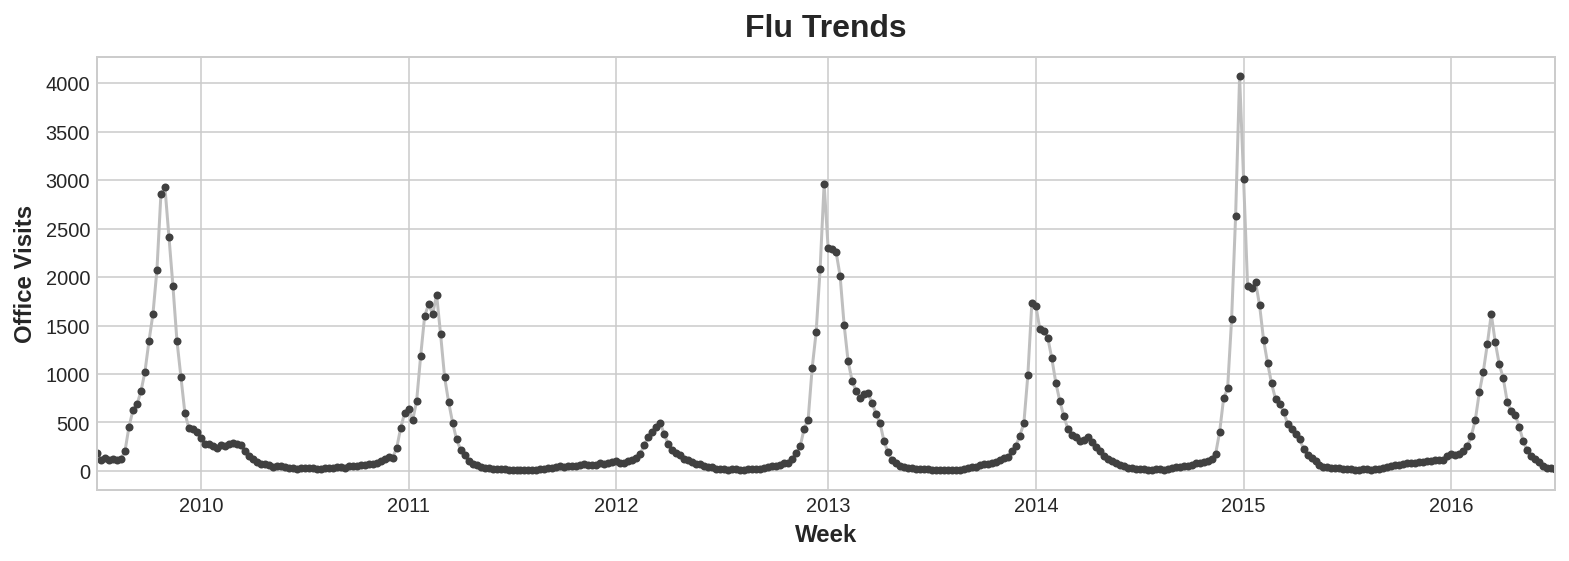

In [15]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import periodogram

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corrrelation = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"corr: {corrrelation:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")

print("1>>>>> \n",flu_trends.head())

flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)

print("2>>>>> \n",flu_trends.head())

flu_trends.drop("Week", axis=1, inplace=True)

print("3>>>>> \n",flu_trends.head())

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")


Our Flu Trends data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

The most commonly used measure of serial dependence is known as autocorrelation, which is simply the correlation a time series has with one of its lags.

Let's take a look at the lag and autocorrelation plots first:

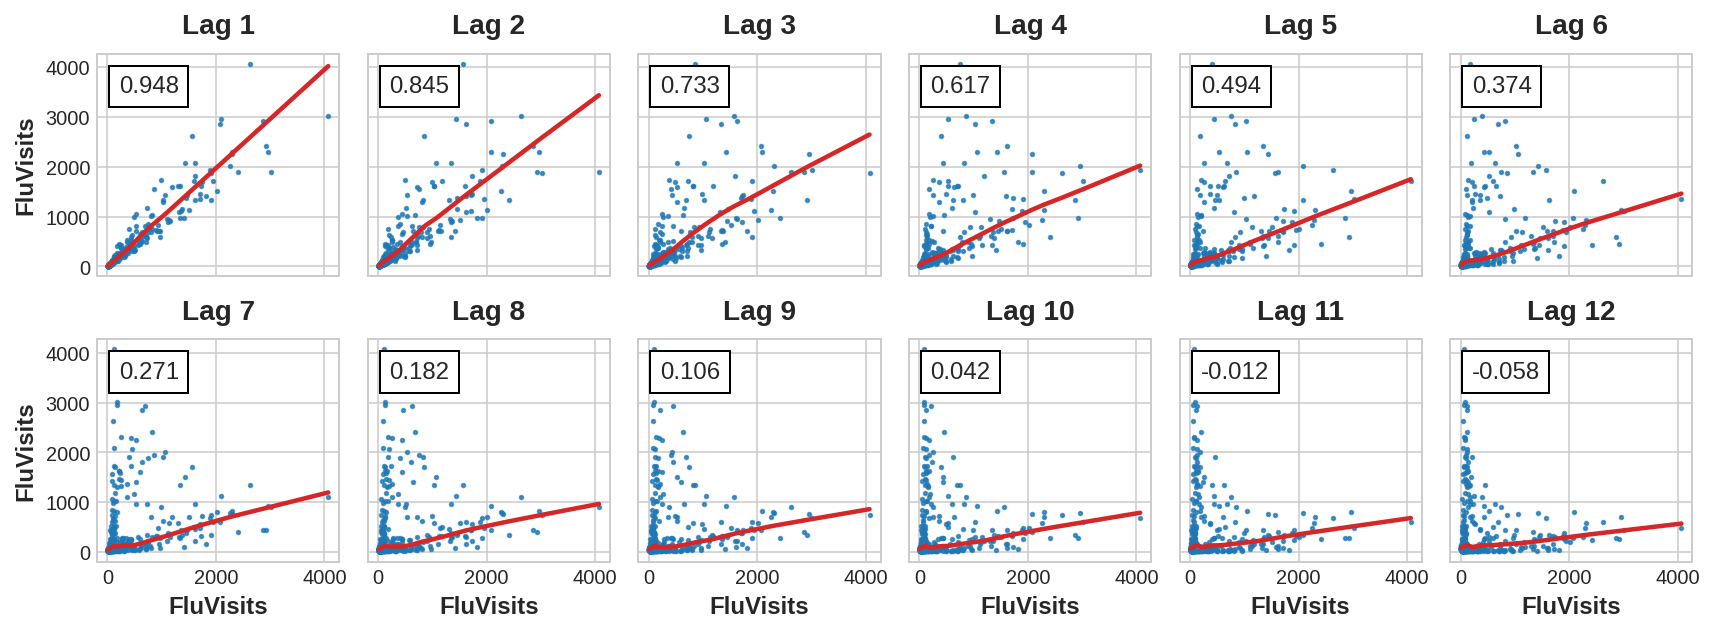

In [16]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)

The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. 

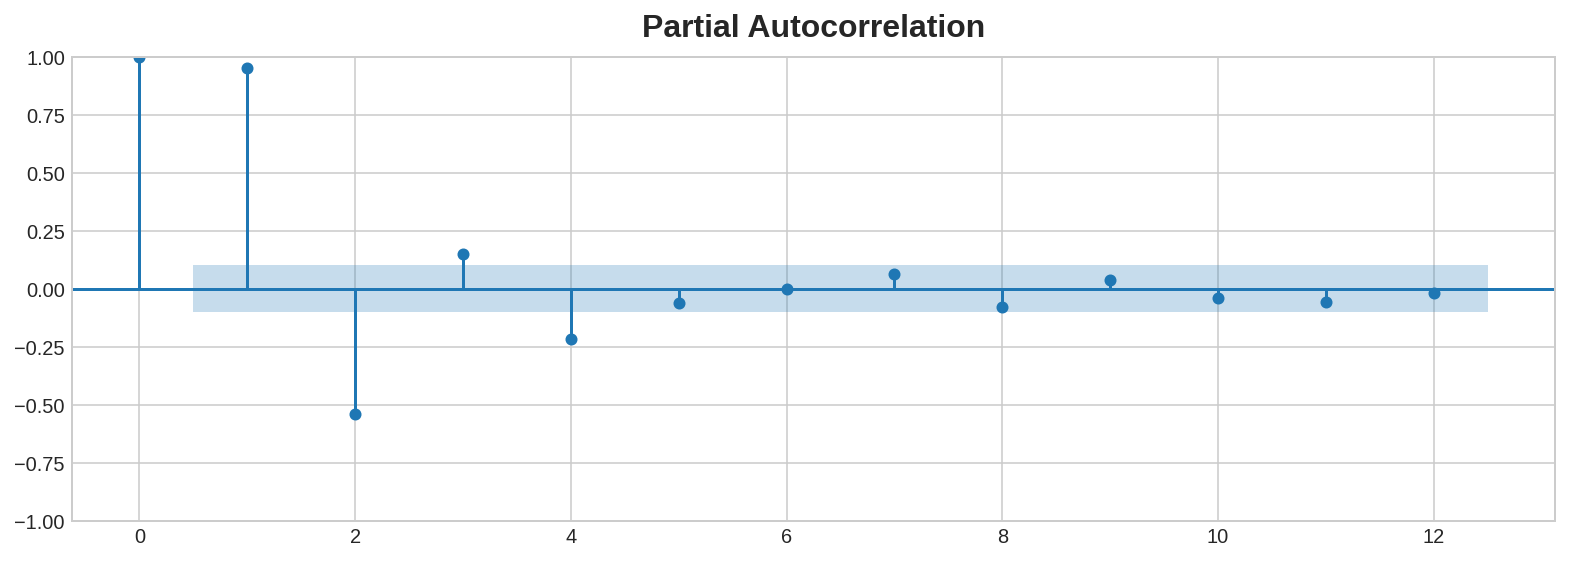

In [14]:
_ = plot_pacf(flu_trends.FluVisits, lags=12) # plot partial autocorrelation - lag up to 12 weeks